In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets, utils
from torch.utils.data import DataLoader, IterableDataset, Dataset, Subset
from tqdm import tqdm
import numpy as np
import torch
import matplotlib.pyplot as plt
import random

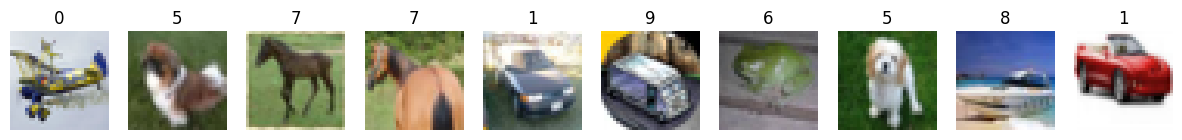

In [2]:
# load cifar10
def load_cifar10(batch_size=128, train=True):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    trainset = datasets.CIFAR10(root='./data', train=train, download=True, transform=transform)
    testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True)
    return train_loader, test_loader
train_loader_cifar, test_loader_cifar = load_cifar10()
# display some images for CIFAR10
def display_images_cifar(loader):
    import matplotlib.pyplot as plt
    for images, labels in loader:
        fig, ax = plt.subplots(1, 10, figsize=(15, 2))
        for i in range(10):
            ax[i].imshow(images[i].permute(1, 2, 0) / 2 + 0.5)  # unnormalize
            ax[i].set_title(labels[i].item())
            ax[i].axis('off')
        plt.show()
        break
display_images_cifar(train_loader_cifar)

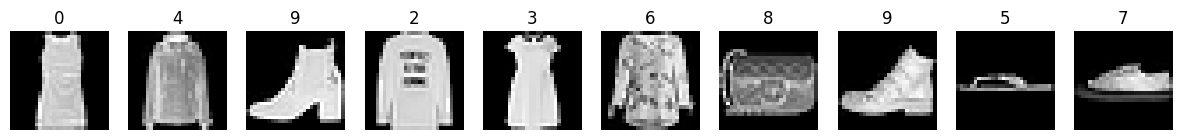

In [3]:
# load mnist dataset
def load_mnist(batch_size=64, train=True):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    trainset = datasets.FashionMNIST(root='./data', train=train, download=True, transform=transform)
    testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

train_loader, test_loader = load_mnist()
# display some images
def display_images(loader):
    import matplotlib.pyplot as plt
    for images, labels in loader:
        fig, ax = plt.subplots(1, 10, figsize=(15, 2))
        for i in range(10):
            ax[i].imshow(images[i].squeeze(), cmap='gray')
            ax[i].set_title(labels[i].item())
            ax[i].axis('off')
        plt.show()
        break
display_images(train_loader)

In [3]:
# load ImageNet-1K
data_dir = '/nethome/zwang910/file_storage/datasets/ImageNet'
# ———— Transforms ————
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std =[0.229, 0.224, 0.225])

train_tf = transforms.Compose([
    # transforms.RandomResizedCrop(224),
    # transforms.RandomHorizontalFlip(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

val_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])
# ———— Use torchvision.datasets.ImageNet ————
# NOTE: insists that `train/` and `val/` are organized into class subfolders.
train_dataset = datasets.ImageNet(root=data_dir, split='train', transform=train_tf)
val_dataset   = datasets.ImageNet(root=data_dir, split='val',   transform=val_tf)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True,
                          num_workers=8, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=256, shuffle=False,
                          num_workers=8, pin_memory=True)

In [4]:
class TargetRemappedSubset(Dataset):
    """
    Wraps a Subset and remaps its targets via a given dict.
    """
    def __init__(self, subset: Subset, class_map: dict):
        self.subset    = subset
        self.class_map = class_map

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        img, orig_t = self.subset[idx]
        new_t = self.class_map[orig_t]
        return img, new_t


def make_random_imagenet_subset(
    dataset,
    num_classes: int = 10,
    images_per_class: int = 10000,
    seed: int = 101
):
    """
    Returns:
      remapped_subset: a Dataset of size num_classes*images_per_class
                        whose targets run 0 .. num_classes-1
      selected_classes: list of original class-indices (len=num_classes)
    """
    random.seed(seed)

    # build mapping: original class_idx -> list of sample-indices
    class_to_indices = {}
    for idx, (_, cls) in enumerate(dataset.samples):
        class_to_indices.setdefault(cls, []).append(idx)

    # choose classes
    all_classes = list(class_to_indices.keys())
    selected_classes = random.sample(all_classes, num_classes)

    # make a mapping from original -> new index
    class_map = {orig: new for new, orig in enumerate(selected_classes)}

    # sample indices (with replacement if needed)
    subset_inds = []
    for orig in selected_classes:
        inds = class_to_indices[orig]
        if len(inds) >= images_per_class:
            chosen = random.sample(inds, images_per_class)
        else:
            chosen = inds[:] + random.choices(inds, k=images_per_class - len(inds))
        subset_inds.extend(chosen)

    random.shuffle(subset_inds)

    base_subset = Subset(dataset, subset_inds)
    remapped   = TargetRemappedSubset(base_subset, class_map)
    return remapped, selected_classes

# 1) Make your 10-class × 10 000-images subset
train_subset, classes = make_random_imagenet_subset(
    train_dataset,
    num_classes=10,
    images_per_class=1000,
    seed=5454
)
print("Picked classes:", classes)

# 2) Wrap in a DataLoader exactly like your full dataset
train_loader_im1k = DataLoader(
    train_subset,
    batch_size=256,
    shuffle=True,
    num_workers=8,
    pin_memory=True
)

Picked classes: [161, 907, 404, 275, 784, 646, 885, 479, 505, 0]


/tmp/ipykernel_843376/64379420.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax[i].imshow(images[i].permute(1, 2, 0) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.007843130588531533..1.0000000236034394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.7686274466514587].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.019607832670211767..1.0000000236034394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.007843130588531533..1.0000000236034394].
Clipping input data to the valid range for imshow with RGB

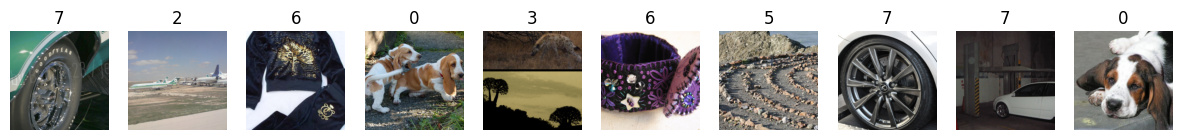

In [5]:
# display some images for ImageNet
def display_images_imagenet(loader):
    import matplotlib.pyplot as plt
    for images, labels in loader:
        fig, ax = plt.subplots(1, 10, figsize=(15, 2))
        for i in range(10):
            ax[i].imshow(images[i].permute(1, 2, 0) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
            ax[i].set_title(labels[i].item())
            ax[i].axis('off')
        plt.show()
        break
display_images_imagenet(train_loader_im1k)

In [3]:
class TaxonConv(nn.Module):
    def __init__(self, in_channels=1, kernel_size=5, n_layers=3, temperature=1.0):
        super(TaxonConv, self).__init__()
        self.in_channels = in_channels
        self.temperature = temperature
        self.n_layers = n_layers
        self.kernel_size = kernel_size

        self.leaves_weights = nn.Parameter(torch.empty(2**n_layers, in_channels, kernel_size, kernel_size))
        nn.init.kaiming_uniform_(self.leaves_weights, a=np.sqrt(5))

        self.leaves_bias = nn.Parameter(torch.zeros(2**n_layers))
        nn.init.zeros_(self.leaves_bias)  # optional, can be learned

        # self.alphas = [
        #     nn.Parameter(torch.zeros(2**i, 1)) for i in range(n_layers)
        # ][::-1]
        # build and register alphas in correct order
        alphas = [nn.Parameter(torch.zeros(2**i, 1)) for i in range(n_layers)]
        alphas.reverse()                  # now top-down
        self.alphas = nn.ParameterList(alphas)

    def forward(self, x):
        B, C, H, W = x.shape
        weights = [self.leaves_weights]
        biases = [self.leaves_bias]
        # bottom‐up convex combinations
        for lvl in range(self.n_layers):
            # α for this level
            alpha_raw = torch.sigmoid(self.alphas[lvl] / self.temperature)
            # combine weights
            child_w = weights[-1]
            child_w = child_w.view(alpha_raw.shape[0], 2, C, self.kernel_size, self.kernel_size)
            a_w = alpha_raw.view(alpha_raw.shape[0], 1, 1, 1, 1)
            a_w = torch.cat([a_w, 1 - a_w], dim=1)           # → (2**lvl, 2, 1,1,1)
            parent_w = torch.sum(a_w * child_w, dim=1)       # → (2**lvl, C, K, K)
            weights.append(parent_w)

            # combine biases the same way
            child_b = biases[-1].view(alpha_raw.shape[0], 2)  # → (2**lvl, 2, 1)
            a_b = alpha_raw.view(alpha_raw.shape[0], 1)      # → (2**lvl, 1, 1)
            a_b = torch.cat([a_b, 1 - a_b], dim=1)               # → (2**lvl, 2, 1)
            parent_b = torch.sum(a_b * child_b, dim=1)           # → (2**lvl, 1)
            biases.append(parent_b)

        weights = weights[::-1]
        biases = biases[::-1] 

        pad = self.kernel_size // 2
        outs = [
            F.conv2d(x, w, bias=b, stride=1, padding=pad)
            for w, b in zip(weights, biases)
        ]

        # concatenate outputs
        out = torch.cat(outs, dim=1) # shape if n_layer=3: # (B, 15, H, W)

        return out

In [4]:
# test:
x = torch.randn(2, 3, 32, 32)  # batch of 2 images, 3 channels, 32x32
model = TaxonConv(in_channels=3, kernel_size=3, n_layers=3)
output = model(x)
# print(f"Output shape: {output.shape}")  # should be (2, 15, 32, 32) for n_layers=3

In [9]:
class OneLayerTaxonCNN(nn.Module):
    def __init__(self, in_channels=1, image_size=32, temperature=1.0):
        super(OneLayerTaxonCNN, self).__init__()
        self.image_size = image_size
        self.in_channels = in_channels
        self.temperature = temperature
        self.taxon_conv1 = TaxonConv(in_channels=self.in_channels, n_layers=4, temperature=self.temperature) # 30 channels
        self.taxon_conv2 = TaxonConv(in_channels=31, n_layers=4, temperature=self.temperature) # 30 channels

        # self.taxon_conv2 = TaxonConv(in_channels=14, n_layers=4, temperature=self.temperature) # 30 channels
        # self.taxon_conv3 = TaxonConv(in_channels=30, n_layers=5, temperature=self.temperature) # 62 channels

        self.fc = nn.Linear(31 * 16 * 16, 10)  # 62 channels, each 4x4 after pooling    
    
    def forward(self, x):
        # print(f"Before first conv: {x.min().item()} {x.max().item()}")  # Debugging line
        x = self.taxon_conv1(x) # shape (batch_size, 14, 32, 32)
        x = F.relu(x)  # apply ReLU activation

        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = self.taxon_conv2(x)
        x = F.relu(x)

        # print(f"After second conv: {x.shape}")

        x = x.view(x.size(0), -1)  # flatten the output
        x = self.fc(x)
        return x

In [10]:
# train on MNIST, log predictions on test set and loss. Also plot them. Train for 5 epochs.
def train_model(model, train_loader, test_loader, epochs=1, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            # print(f"Output shape: {outputs.shape}, Labels shape: {labels.shape}")
            loss = criterion(outputs, labels)
            # print(f"Loss: {loss.item():.4f}, DKL: {dkl.item():.4f}")

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            # print(f"Batch Loss: {loss.item():.4f}")
            # break
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")
        # print(f"Loss: {loss.item():.4f}, DKL: {dkl.item():.4f}")

        # # Evaluate on test set
        # model.eval()
        # correct = 0
        # total = 0
        # with torch.no_grad():
        #     for images, labels in test_loader:
        #         images, labels = images.to(device), labels.to(device)
        #         outputs = model(images)
        #         _, predicted = torch.max(outputs.data, 1)
        #         total += labels.size(0)
        #         correct += (predicted == labels).sum().item()

        # print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Initialize and train the model
# model = ThreeLayerTaxonCNN(in_channels=3, temperature=1.0)


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = OneLayerTaxonCNN(in_channels=3, temperature=1.0).to(device)

train_model(model, train_loader_cifar, train_loader_cifar, epochs=10, lr=0.001)

Epoch 1/10: 100%|██████████| 391/391 [00:13<00:00, 29.78it/s]


Epoch 1, Loss: 1.4453086267651805


Epoch 2/10: 100%|██████████| 391/391 [00:12<00:00, 31.69it/s]


Epoch 2, Loss: 1.116454838334447


Epoch 3/10: 100%|██████████| 391/391 [00:12<00:00, 30.82it/s]


Epoch 3, Loss: 0.9925387166345211


Epoch 4/10: 100%|██████████| 391/391 [00:11<00:00, 32.76it/s]


Epoch 4, Loss: 0.909386019420136


Epoch 5/10: 100%|██████████| 391/391 [00:12<00:00, 30.91it/s]


Epoch 5, Loss: 0.8464710226144327


Epoch 6/10: 100%|██████████| 391/391 [00:12<00:00, 31.24it/s]


Epoch 6, Loss: 0.7913563942055568


Epoch 7/10: 100%|██████████| 391/391 [00:12<00:00, 30.61it/s]


Epoch 7, Loss: 0.7560663489277101


Epoch 8/10: 100%|██████████| 391/391 [00:12<00:00, 31.12it/s]


Epoch 8, Loss: 0.7096938336901653


Epoch 9/10: 100%|██████████| 391/391 [00:12<00:00, 30.79it/s]


Epoch 9, Loss: 0.6754729998538561


Epoch 10/10: 100%|██████████| 391/391 [00:12<00:00, 31.50it/s]

Epoch 10, Loss: 0.643352925548773


In [14]:
def get_taxonconv_weights(taxon_conv):
    """
    Recompute and return the list of weight tensors for each level in a TaxonConv.
    Returns a list of torch.Tensor with shapes:
      [root: (1, in_ch, k, k), level1: (2, in_ch, k, k), ..., leaves: (2**n_layers, in_ch, k, k)]
    """
    weights = [taxon_conv.leaves_weights]
    for alpha in taxon_conv.alphas:
        alpha_sig = torch.sigmoid(alpha / taxon_conv.temperature)
        children = weights[-1]
        # reshape into (num_parents, 2, in_ch, k, k)
        children = children.view(alpha_sig.shape[0], 2, 
                                 taxon_conv.in_channels, 
                                 taxon_conv.kernel_size, 
                                 taxon_conv.kernel_size)
        a = alpha_sig.view(alpha_sig.shape[0], 1, 1, 1, 1)
        a = torch.cat([a, 1 - a], dim=1)
        parent = (a * children).sum(dim=1)
        weights.append(parent)
    return weights[::-1]  # root first, leaves last

def visualize_taxonconv_filters(model, layer_idx=0, n_cols=8):
    """
    Visualize filters at a given layer of TaxonConv inside OneLayerTaxonCNN.
    
    Args:
        model:       instance of OneLayerTaxonCNN
        layer_idx:   index of the tree-level to visualize (0=root, ..., n_layers=leaves)
        n_cols:      number of columns for the grid display
    """
    # Extract TaxonConv submodule
    taxon_conv = model.taxon_conv1
    # Get the computed weights list
    weights = get_taxonconv_weights(taxon_conv)
    w_tensor = weights[layer_idx]  # shape: [out_ch, in_ch, k, k]
    
    # Convert to numpy
    w_np = w_tensor.detach().cpu().numpy()
    n_filters, in_ch, k, _ = w_np.shape
    
    # Normalize per filter
    mins = w_np.min(axis=(1,2,3), keepdims=True)
    maxs = w_np.max(axis=(1,2,3), keepdims=True)
    w_norm = (w_np - mins) / (maxs - mins + 1e-5)
    
    # Grid setup
    n_rows = int(np.ceil(n_filters / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))
    axes = axes.flatten()
    
    for i in range(n_filters):
        filt = w_norm[i]  # (in_ch, k, k)
        if in_ch > 1:
            filt = np.transpose(filt, (1, 2, 0))  # to (k, k, in_ch)
        axes[i].imshow(filt, cmap='gray' if in_ch == 1 else None)
        axes[i].axis('off')
    
    # Turn off any extra axes
    for ax in axes[n_filters:]:
        ax.axis('off')
    
    plt.suptitle(f"TaxonConv Level {layer_idx} Filters ({n_filters} filters, in_ch={in_ch}, k={k})")
    plt.tight_layout()
    plt.show()

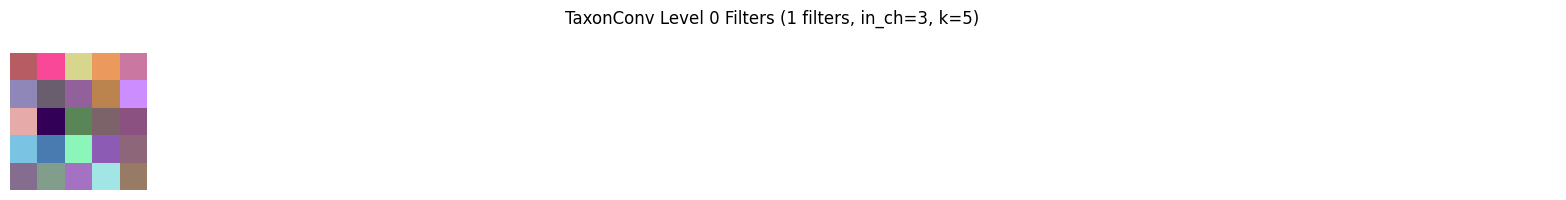

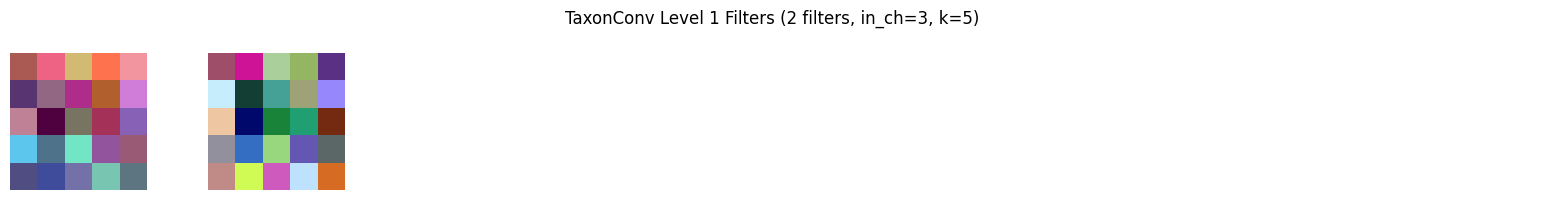

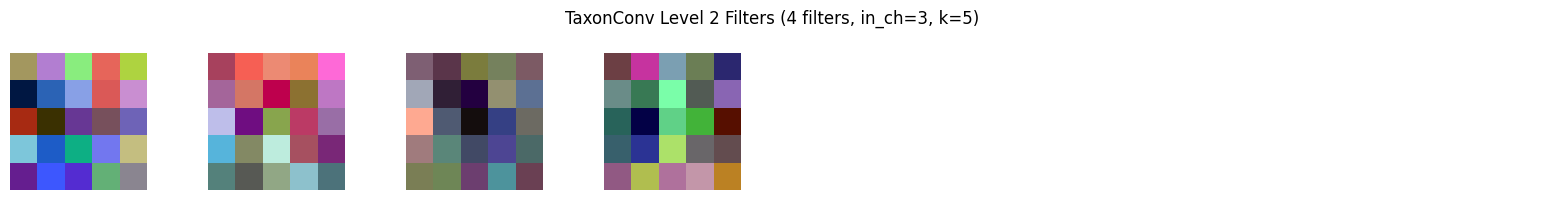

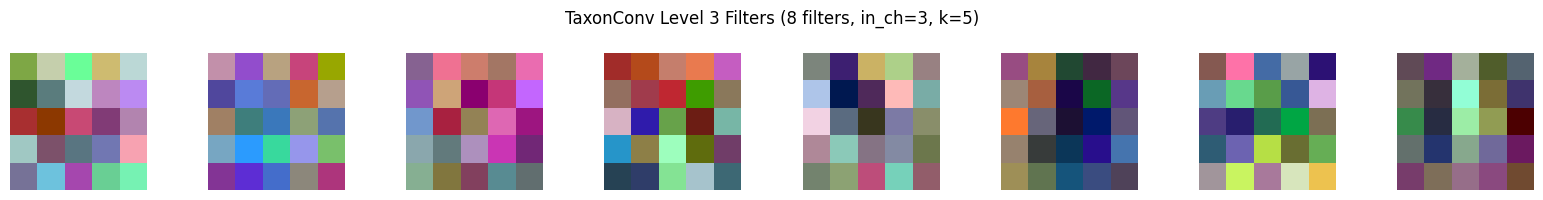

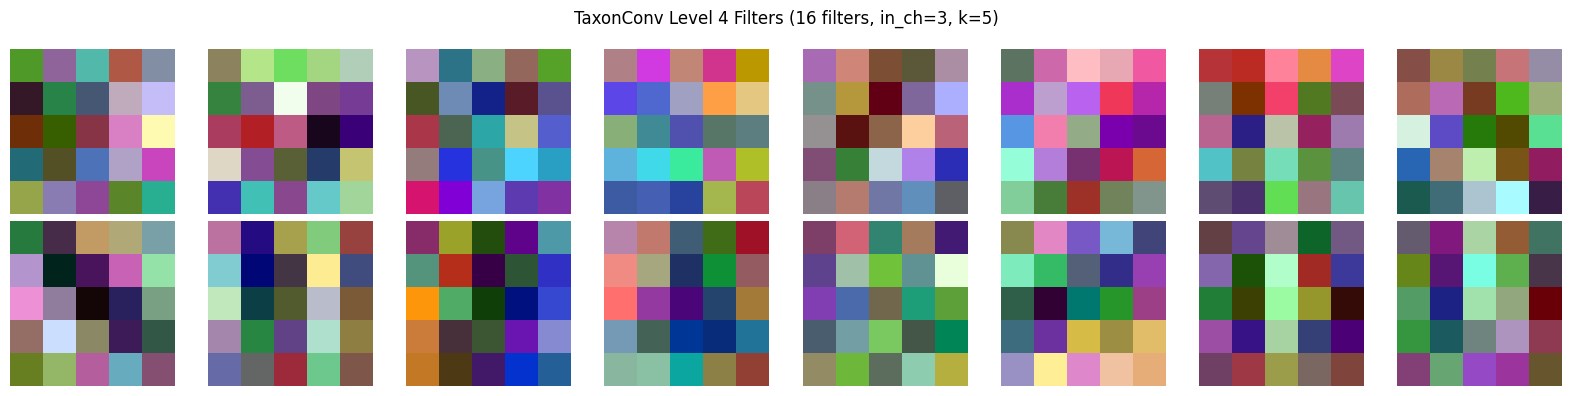

In [15]:
# Visualize root filters
# visualize_taxonconv_filters(model, layer_idx=0, n_cols=8)

# Visualize every tree level
for lvl in range(model.taxon_conv1.n_layers + 1):
    visualize_taxonconv_filters(model, layer_idx=lvl, n_cols=8)